In [14]:
%matplotlib inline
%reload_ext line_profiler

import time
from urllib.request import urlopen

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import parallel_coordinates


class Bicluster:
    def __init__(self, rows, cols, inverted_rows, msr):
        if isinstance(rows, np.ndarray) and isinstance(cols, np.ndarray) and isinstance(inverted_rows, np.ndarray):
            self.rows = rows
            self.cols = cols
            self.inverted_rows = inverted_rows
        else:
            raise Exception("rows, cols and inverted_rows must be np.ndarray. TIPS: np.array(rows_list) is the way.")
        self.msr = msr

    def __str__(self):
        return "Shape:{0}, {1}\tMSR:{2}".format(self.rows.size+self.inverted_rows.size, self.cols.size, self.msr)


def read_matrix(filename, url=False):
    """
    Read a .matrix file from a path or a url
    Parameters
    ----------
    filename : string
        The path or the url of the .matrix file
    url : boolean
        Indicate whether the name parameter is an url or a path
    Returns
    -------
    Numpy array
        The file as a Numpy array
    """
    try:
        if url:
            lines = urlopen(filename).read().decode('utf-8').strip().split('\n')
        else:
            matrix_file = open(filename, "r")
            lines = matrix_file.read().strip().split("\n")
            matrix_file.close()
    except Exception as e:
        raise e;
        
    lines = list(' -'.join(line.split('-')).split(' ') for line in lines)
    lines = list(list(int(i) for i in line if i) for line in lines)
    return np.array(lines)


def clean(matrix, missing_value=-1):
    """
    Replace the missing value with random one's.
    Parameters
    ----------
    matrix : Numpy array
        Values matrix
    missing_values : float
        Value to be considered as missing (default -1)
    Returns
    -------
    Numpy array
        missing
    """
    temp_matrix = np.copy(matrix)
    generator = np.random.RandomState(0)
    idx = np.where(temp_matrix == missing_value)
    temp_matrix[idx] = generator.randint(0, 801, len(idx[0]))
    return temp_matrix


def mean_squared_residue_np(matrix, rows, cols, inverted_rows=np.array([])):
    """
    Compute the MSR(Mean Squared Residue) of the submatrix defined by rows,cols and inverted_rows over the matrix.
    Parameters
    ----------
    matrix : Numpy array
        Values matrix
    rows : Numpy array
        Array of rows indexes of submatrix
    cols : Numpy array
        Array of columns indexes of submatrix
    inverted_rows : Numpy array (default np.array([]))
        Array of inverted rows indexesof submatrix
    Returns
    -------
    float
        The MSR of the submatrix
    """
    matrix2 = matrix[rows][:, cols]
    if inverted_rows.size > 0:
        matrix_inverted = np.flip(matrix[inverted_rows][:, cols], 1)
        matrix2 = np.append(matrix2, matrix_inverted, 0)

    def msr(a): return (np.power(a - a.mean(axis=1, keepdims=True) -
                                 a.mean(axis=0) + a.mean(), 2).mean())
    return msr(matrix2)


def multiple_deletion_node_np(matrix, msr_threshold=300, alpha=1.2):
    """
    Multiple deletion node on matrix.
    Parameters
    ----------
    matrix : Numpy array
        Values matrix
    msr_threshold : float (default 300)
        Minimum MSR of submatrix to be considered acceptable
    alpha : float (default 1.2)
        Value of alpha
    Returns
    -------
    A tuple of Numpy array
        The rows and columns indexes of the submatrix obtained.
    """
    rows = np.arange(0, matrix.shape[0])
    cols = np.arange(0, matrix.shape[1])
    msr = mean_squared_residue_np(matrix, rows, cols)
    print("MSR before multiple_deletion_node\t" + str(msr))
    rows_mean = matrix[rows].mean(axis=1, keepdims=True)
    cols_mean = matrix[rows][:, cols].mean(axis=0)
    deletion = True
    while deletion and msr > msr_threshold:

        arr = matrix[rows][:, cols] - rows_mean - cols_mean
        arr += np.mean(matrix[rows][:, cols])
        msr_rows = np.power(arr, 2).mean(axis=1)
        rows_to_remove = msr_rows <= (alpha * msr)
        rows = rows[rows_to_remove]
        msr = mean_squared_residue_np(matrix, rows, cols)
        rows_mean = matrix[rows].mean(axis=1, keepdims=True)
        cols_mean = matrix[rows][:, cols].mean(axis=0)

        cols_to_remove = np.array([])
        if matrix.shape[1] > 100:
            arr = matrix[rows][:, cols] - rows_mean - cols_mean
            arr += np.mean(matrix[rows][:, cols])
            msr_cols = np.power(arr, 2).mean(axis=0)
            cols_to_remove = msr_cols <= (alpha * msr)
            cols = cols[cols_to_remove]
            msr = mean_squared_residue_np(matrix, rows, cols)
            rows_mean = matrix[rows].mean(axis=1, keepdims=True)
            cols_mean = matrix[rows][:, cols].mean(axis=0)
        elements_removed = np.count_nonzero(
            rows_to_remove == False) + np.count_nonzero(cols_to_remove == False)

        if(elements_removed == 0):
            deletion = False

    print("MSR after multiple_deletion_node\t" + str(msr))
    return rows, cols


def single_deletion_node_np(matrix, rows, cols, msr_threshold=300):
    """
    Single deletion node on submatrix defined by rows and cols.
    Parameters
    ----------
    matrix : Numpy array
        Values matrix
    rows : Numpy array
        Array of rows indexes of submatrix
    cols : Numpy array
        Array of columns indexes of submatrix
    msr_threshold : float (default 300)
        Minimum MSR of submatrix to be considered acceptable
    Returns
    -------
    A tuple of Numpy array
        The rows and columns indexes of the submatrix obtained.
    """
    msr = mean_squared_residue_np(matrix, rows, cols)
    print("MSR before single_deletion_node\t\t" + str(msr))
    rows_mean = matrix[rows].mean(axis=1, keepdims=True)
    cols_mean = matrix[rows][:, cols].mean(axis=0)
    while msr > msr_threshold:

        arr = matrix[rows][:, cols] - rows_mean - cols_mean
        arr += np.mean(matrix[rows][:, cols])
        msr_rows = np.power(arr, 2).mean(axis=1)
        msr_cols = np.power(arr, 2).mean(axis=0)
        rows_max = np.amax(msr_rows)
        cols_max = np.amax(msr_cols)
        if rows_max > cols_max:
            rows = np.delete(rows, np.argmax(msr_rows))
        else:
            cols = np.delete(cols, np.argmax(msr_cols))
        msr = mean_squared_residue_np(matrix, rows, cols)
        rows_mean = matrix[rows].mean(axis=1, keepdims=True)
        cols_mean = matrix[rows][:, cols].mean(axis=0)

    print("MSR after single_deletion_node\t\t" + str(msr))
    return rows, cols


def node_addition_np(matrix, rows, cols):
    """
    Node addition on submatrix defined by rows and cols.
    Parameters
    ----------
    matrix : Numpy array
        Values matrix
    rows : Numpy array
        Array of rows indexes of submatrix
    cols : Numpy array
        Array of columns indexes of submatrix
    Returns
    -------
    A tuple of Numpy array
        The rows and columns indexes of the submatrix obtained.
    """
    inverted_rows = np.array([])
    matrix_rows = np.arange(0, matrix.shape[0])
    matrix_cols = np.arange(0, matrix.shape[1])
    msr = mean_squared_residue_np(matrix, rows, cols)
    print("MSR before node_addition\t\t" + str(msr))
    rows_mean = matrix[rows].mean(axis=1, keepdims=True)
    cols_mean = matrix[rows][:, cols].mean(axis=0)
    rows_not = np.setdiff1d(matrix_rows, rows)
    cols_not = np.setdiff1d(matrix_cols, cols)
    rows_mean_not = matrix[rows_not].mean(axis=1, keepdims=True)
    cols_mean_not = matrix[rows][:, cols_not].mean(axis=0)
    addition = True
    while addition:

        arr = matrix[rows_not][:, cols] - rows_mean_not - cols_mean
        arr += np.mean(matrix[rows][:, cols])  # dubbio
        msr_rows = np.power(arr, 2).mean(axis=1)
        rows_to_append = msr_rows < msr
        rows = np.append(rows, rows_not[rows_to_append])
        rows_not = np.setdiff1d(rows_not, rows_not[rows_to_append])
        msr = mean_squared_residue_np(matrix, rows, cols, inverted_rows)
        rows_mean = matrix[rows].mean(axis=1, keepdims=True)
        cols_mean = matrix[rows][:, cols].mean(axis=0)
        rows_mean_not = matrix[rows_not].mean(axis=1, keepdims=True)
        cols_mean_not = matrix[rows][:, cols_not].mean(axis=0)

        arr = matrix[rows][:, cols_not] - rows_mean - cols_mean_not
        arr += np.mean(matrix[rows][:, cols])  # dubbio
        msr_cols = np.power(arr, 2).mean(axis=0)
        cols_to_append = msr_cols < msr
        cols = np.append(cols, cols_not[cols_to_append])
        cols_not = np.setdiff1d(cols_not, cols_not[cols_to_append])
        msr = mean_squared_residue_np(matrix, rows, cols, inverted_rows)
        rows_mean = matrix[rows].mean(axis=1, keepdims=True)
        cols_mean = matrix[rows][:, cols].mean(axis=0)

        arr = -matrix[rows_not][:, cols] + rows_mean_not - cols_mean
        arr += np.mean(matrix[rows][:, cols])  # dubbio
        msr_rows = np.power(arr, 2).mean(axis=1)
        rows_to_append = msr_rows < msr
        if(inverted_rows.size == 0):
            inverted_rows = rows_not[rows_to_append]
        else:
            inverted_rows = np.append(inverted_rows, rows_not[rows_to_append])
        rows_not = np.setdiff1d(rows_not, rows_not[rows_to_append])
        msr = mean_squared_residue_np(matrix, rows, cols, inverted_rows)
        rows_mean = matrix[rows].mean(axis=1, keepdims=True)
        cols_mean = matrix[rows][:, cols].mean(axis=0)
        rows_mean_not = matrix[rows_not].mean(axis=1, keepdims=True)
        cols_mean_not = matrix[rows][:, cols_not].mean(axis=0)

        elements_removed = np.count_nonzero(
            rows_to_append == True) + np.count_nonzero(cols_to_append == True)

        if(elements_removed == 0):
            addition = False

    print("MSR after node_addition\t\t\t" + str(msr))
    return rows, cols, inverted_rows, msr


def hide_bicluster_np(matrix, rows, cols, inverted_rows=np.array([])):
    """
    Mask the submatrix defined by rows, cols and inverted_rows on matrix with random values.
    Parameters
    ----------
    matrix : Numpy array
        Values matrix
    rows : Numpy array
        Array of rows indexes of submatrix
    cols : Numpy array
        Array of columns indexes of submatrix
    inverted_rows : Numpy array (default np.array([]))
        Array of inverted rows indexesof submatrix
    Returns
    -------
    Numpy array
        A copy of matrix in which submatrix has been masked.
    """
    matrix2 = np.copy(matrix)
    generator = np.random.RandomState(0)
    for row in rows:
        matrix2[row, cols] = generator.randint(0, 801, cols.size)
        # print matrix2[row,cols]
    if inverted_rows.size > 0:
        for row in inverted_rows:
            matrix2[row, cols] = generator.randint(0, 801, cols.size)
    print("Last bicluster masked")
    return matrix2


def get_bicluster(matrix, bicluster):
    """
    Get a submatrix given rows,columns and inveted rows indexes.
    Parameters
    ----------
    matrix : Numpy array
        Values matrix
    bicluster : Bicluster object 
    Returns
    -------
    Numpy array
        Submatrix.
    """
    rows = np.append(bicluster.rows, bicluster.inverted_rows)
    cols = bicluster.cols
    rows.sort()
    cols.sort()
    return matrix[rows][:, cols]


def plot_bicluster(matrix, bicluster, name="Bicluster"):
    """
    Plot a bicluster.
    Parameters
    ----------
    matrix: Numpy array
        Starting values matrix.
    bicluster : Bicluster object
        Bicluster to plot
    name : string (default "Bicluster")
        Name of plotted bicluster.
    Returns
    -------
    None
    """
    bicluster_matrix = get_bicluster(matrix, bicluster)
    df = pd.DataFrame(bicluster_matrix)
    df["index"] = df.index.values
    parallel_coordinates(df, "index", linewidth=1.0)
    plt.title(name + "\nMean Squared Residue: " + str(bicluster.msr))
    plt.xlabel('Condition')
    plt.ylabel('Expression level')
    plt.gca().legend_ = None
    plt.show()


def find_biclusters_np(matrix, n_of_bicluster=100, msr_threshold=300, alpha=1.2):
    """
    Find biclusters in a given matrix.
    Parameters
    ----------
    matrix : Numpy array
        Values matrix
    n_of_bicluster : int
        Number of desired biclusters to find
    msr_threshold : float (default 300)
        Minimum MSR of submatrix to be considered acceptable
    alpha : float (default 1.2)
        Value of alpha(see algorithm definition)
    Returns
    -------
    List of Bicluster object
        The list of biclusters.
    """
    matrixA = np.copy(matrix)
    biclusters = []
    for i in range(n_of_bicluster):
        rowsB, colsB = multiple_deletion_node_np(
            matrixA, msr_threshold=msr_threshold, alpha=alpha)
        rowsC, colsC = single_deletion_node_np(
            matrixA, rowsB, colsB, msr_threshold=msr_threshold)
        rowsD, colsD, invD, msr = node_addition_np(matrix, rowsC, colsC)
        print("Bicluster " + str(i))
        biclusters.append(Bicluster(rowsD, colsD, invD, msr))
        matrixA = hide_bicluster_np(matrixA, rowsD, colsD, invD)
    return biclusters

# Main #

In [15]:
#data = read_matrix("Datasets\yeast.matrix")
data = read_matrix(
    "http://arep.med.harvard.edu/biclustering/lymphoma.matrix", url=True)
data = clean(data)

In [16]:
start = time.time()
biclusters = find_biclusters_np(data, n_of_bicluster=3)
end = (time.time() - start)
print(end, "seconds")

MSR before multiple_deletion_node	47866.73130975362
MSR after multiple_deletion_node	1215.3621301783155
MSR before single_deletion_node		1215.3621301783155
MSR after single_deletion_node		292.8830102040816
MSR before node_addition		292.8830102040816
MSR after node_addition			287.87151111111115
Bicluster 0
Last bicluster masked
MSR before multiple_deletion_node	48008.24933354032
MSR after multiple_deletion_node	1454.3506573159627
MSR before single_deletion_node		1454.3506573159627
MSR after single_deletion_node		291.80111916089965
MSR before node_addition		291.80111916089965
MSR after node_addition			307.61768977743606
Bicluster 1
Last bicluster masked
MSR before multiple_deletion_node	48155.036770664585
MSR after multiple_deletion_node	1267.412660095897
MSR before single_deletion_node		1267.412660095897
MSR after single_deletion_node		279.34331109687696
MSR before node_addition		279.34331109687696
MSR after node_addition			279.34331109687696
Bicluster 2
Last bicluster masked
1.96879053

In [17]:
best_bicluster = sorted(biclusters, key=lambda bicluster: bicluster.msr)[0]

In [ ]:
print(str(best_bicluster))

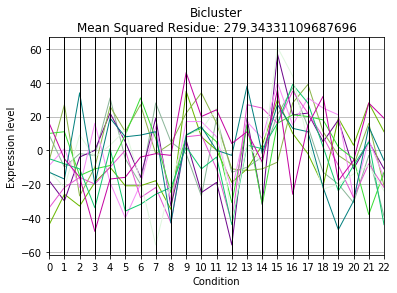

In [18]:
plot_bicluster(data, best_bicluster)